<a href="https://colab.research.google.com/github/WEBSTERMASTER777/pdd/blob/add_first_commit_files/TripletLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step by step guide for training Triplet model

## Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Install requirements

In [2]:
!git clone -b refactor https://github.com/WEBSTERMASTER777/pdd.git

Cloning into 'pdd'...
remote: Enumerating objects: 699, done.
remote: Counting objects: 100% (349/349), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 699 (delta 225), reused 346 (delta 225), pack-reused 350
Receiving objects: 100% (699/699), 362.65 KiB | 3.05 MiB/s, done.
Resolving deltas: 100% (439/439), done.


In [ ]:
!ls 

gdrive	pdd  sample_data


In [3]:
!pip install -r pdd/requirements.txt -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 294 kB 4.2 MB/s 
     |████████████████████████████████| 90 kB 9.3 MB/s 
     |████████████████████████████████| 11.5 MB 46.9 MB/s 
     |████████████████████████████████| 15.3 MB 35.9 MB/s 
     |████████████████████████████████| 2.1 MB 39.6 MB/s 
     |████████████████████████████████| 67 kB 5.7 MB/s 
     |████████████████████████████████| 227 kB 43.4 MB/s 
     |████████████████████████████████| 268 kB 49.1 MB/s 
     |████████████████████████████████| 22.3 MB 1.6 MB/s 
     |████████████████████████████████| 27.4 MB 60.5 MB/s 
     |█████████████                   | 834.1 MB 1.5 MB/s eta 0:13:19tcmalloc: large alloc 1147494400 bytes == 0x560981b52000 @  0x7fcdde29b615 0x56091b99217c 0x56091ba7247a 0x56091b994f9d 0x56091ba86d4d 0x56091ba08ec8 0x56091ba03a2e 0x56091b99688a 0x56091ba08d30 0x56091ba03a2e 0x56091b99688a 0x56091ba05719 0x56091ba87b76 0x56091ba04d95 0x56091ba87b76

In [4]:
pip install pillow==6.2.1

     |████████████████████████████████| 2.1 MB 4.2 MB/s 
  Attempting uninstall: pillow
    Found existing installation: Pillow 6.2.2
    Uninstalling Pillow-6.2.2:
      Successfully uninstalled Pillow-6.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bokeh 2.3.3 requires pillow>=7.1.0, but you have pillow 6.2.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## Import modules and init constant

In [1]:
from pdd.pdd.triplettorch import HardNegativeTripletMiner
from pdd.pdd.triplettorch import AllTripletMiner
from pdd.pdd.triplettorch import TripletDataset

In [2]:
import numpy as np
import torch
import time
import os

from torch.utils.data import DataLoader
from torchvision.models import mobilenet_v2
from torchvision import transforms
from torch import nn
import random
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt

import torch.nn as nn
import numpy as np
import torch

import torch 
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import cosine
from sklearn import metrics



RANDOM_SEED=13
CUDN_DETERMENISTIC=True
NUM_CLASSES=15
COUNT_NEIGHBOR_EXP_1=1
COUNT_NEIGHBOR_EXP_2=3
METRIC_KNN=cosine


In [ ]:
!rm -r pdd

## Fix random seed

In [3]:
def fix_random_seed(seed, cudnn_determenistic=False):
    random.seed(seed);
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=cudnn_determenistic

In [4]:
fix_random_seed(RANDOM_SEED,CUDN_DETERMENISTIC)

In [40]:
rm -r flower/

In [11]:
!ls gdrive/MyDrive/ИТМО/

 Basics,_numpy,_pandas_in_Python.ipynb	'Notebooks and data from lab 2.zip'
'Classification Metrics.ipynb'		 RegularSeasonCompactResults.csv
 flower.zip				 stat
 link.gdoc				'Task #1.zip'
 link.txt				 yolov5.zip
 MobileApp				 преза


In [15]:
!unzip 'gdrive/MyDrive/ИТМО/flower.zip' -d flower

Archive:  gdrive/MyDrive/ИТМО/flower.zip
  inflating: flower/flower_photos/LICENSE.txt  
  inflating: flower/flower_photos/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flower/flower_photos/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flower/flower_photos/daisy/10172379554_b296050f82_n.jpg  
  inflating: flower/flower_photos/daisy/10172567486_2748826a8b.jpg  
  inflating: flower/flower_photos/daisy/10172636503_21bededa75_n.jpg  
  inflating: flower/flower_photos/daisy/102841525_bd6628ae3c.jpg  
  inflating: flower/flower_photos/daisy/1031799732_e7f4008c03.jpg  
  inflating: flower/flower_photos/daisy/10391248763_1d16681106_n.jpg  
  inflating: flower/flower_photos/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flower/flower_photos/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flower/flower_photos/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flower/flower_photos/daisy/10466290366_cc72e33532.jpg  
  inflating: flower/flower_photos/daisy/10466558316_a7198b87e2.jpg  
  infla

## Data preprocessing

In [16]:
import numpy as np
import os

from torch.utils.data import Dataset
from torch.utils.data import Sampler
from torchvision.datasets import ImageFolder


class AllCropsDataset(Dataset):
    def __init__(self, image_folder, subset='', transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        # data subset (train, test)
        self.subset = subset
        # store each crop data
        self.datasets = []
        self.crops = []
        self.samples = []
        self.imgs = []
        self.classes = []
        self.targets = []
        self.class_to_idx = {}
        # iterate over all folders 
        # with all crops
        for i, d in enumerate(os.listdir(image_folder)):
            self.crops.append(d)
            # full path to the folder
            d_path = os.path.join(image_folder, d, self.subset)
            # attribute name to set attribute 
            attr_name = '%s_ds' % d.lower()
            print("Load '%s' data" % attr_name)
            # set the attribute with the specified name
            setattr(self, attr_name, ImageFolder(d_path))
            # add the dataset to datasets list
            self.datasets.append(getattr(self, attr_name))
            # get dataset attribute
            ds = getattr(self, attr_name)
            # add attr targets to the global targets
            ds_targets = [x+len(self.classes) for x in ds.targets]
            self.targets.extend(ds_targets)
            # add particular classes to the global classes' list
            ds_classes = []
            for c in ds.classes:
                new_class = '__'.join([d, c])
                self.class_to_idx[new_class] = len(self.classes) + ds.class_to_idx[c]
                ds_classes.append(new_class)
            self.classes.extend(ds_classes)
            # imgs attribute has form (file_path, target)
            ds_imgs, _ = zip(*ds.imgs)
            # images and samples are equal
            self.imgs.extend(list(zip(ds_imgs, ds_targets)))
            self.samples.extend(list(zip(ds_imgs, ds_targets)))
            
            
    def __len__(self):
        return len(self.samples)
      
      
    def __getitem__(self, idx):
        path, target = self.samples[idx]
        img = self.datasets[0].loader(path)
        
        if self.transform is not None:
            img = self.transform(img)
        
        if self.target_transform is not None:
            target = self.target_transform(target)
            
        return img, target
      
      
    

In [17]:
DATA_PATH = 'flower/'

def prepare_datasets(data_path):
    train_ds = AllCropsDataset(
        data_path,
        subset='train',
        transform=transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])]),
        target_transform=torch.tensor)

    test_ds = AllCropsDataset(
        data_path,
        subset='test',
        transform=transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])]),
        target_transform=torch.tensor)

    # print statistics
    print('Train size:', len(train_ds))
    print('Test size:', len(test_ds))
    print('Number of samples in the dataset:', len(train_ds))
    print('Crops in the dataset:', train_ds.crops)
    print('Total number of classes in the dataset:', len(train_ds.classes))
    print('Classes with the corresponding targets:')
    print(train_ds.class_to_idx)

    return train_ds, test_ds

In [18]:
import numpy as np
import shutil
import os

from glob import glob
from tqdm import tqdm
from tqdm.notebook import tqdm

TEST_SIZE = 0.2
RS = 42
def _remove_path_if_exists(path):
    if os.path.exists(path):
        if os.path.isfile(path):
            os.remove(path)
        else:
            shutil.rmtree(path)

def _makedir_and_copy2(path, dirname, fnames):
    path_for_saving_files = os.path.join(path, dirname)
    os.makedirs(path_for_saving_files)

    for fname in fnames:
        shutil.copy2(fname, path_for_saving_files)

def datadir_train_test_split(origin_path, test_size, random_state=0):
    """Splits the data in directory on train and test.
    # Arguments
        origin_path: path to the original directory
        test_size: the size of test data fraction
    # Returns
        Tuple of paths: `(train_path, test_path)`.
    """
    print("\n\nSplit `%s` directory" % origin_path)
    print("Test size: %.2f" % test_size)
    print("Random state: {}".format(random_state))
    train_path = os.path.join(origin_path, 'train')
    test_path = os.path.join(origin_path, 'test')   
    _remove_path_if_exists(train_path)
    _remove_path_if_exists(test_path)

    try:
        subfolders = glob(os.path.join(origin_path, "*", ""))
        # if train/test split is already done
        if set(subfolders) == set(['train', 'test']):
            return (train_path, test_path)
        # if train/test split is required
        # recreate train/test folders
        os.makedirs(train_path)
        os.makedirs(test_path)
        print(subfolders)
        for folder in tqdm(subfolders, total=len(subfolders), ncols=57):
            # collect all images
            img_fnames = []
            for ext in ["*.jpg", "*.png", "*jpeg"]:
                img_fnames.extend(
                    glob(os.path.join(folder, ext)))
            # set random state parameter
            rs = np.random.RandomState(random_state)
            # shuffle array
            rs.shuffle(img_fnames)
            # split on train and test
            n_test_files = int(len(img_fnames)*test_size)
            test_img_fnames = img_fnames[:n_test_files]
            train_img_fnames = img_fnames[n_test_files:]
            # copy train files into `train_path/folder`
            folder_name = os.path.basename(os.path.dirname(folder))
            _makedir_and_copy2(train_path, folder_name, train_img_fnames)
            # copy test files into `test_path/folder`
            _makedir_and_copy2(test_path, folder_name, test_img_fnames)

        for folder in subfolders:
            shutil.rmtree(folder)

    except:
        _remove_path_if_exists(train_path)
        _remove_path_if_exists(test_path)
        raise 
        
    return (train_path, test_path)

In [19]:
def split_on_train_and_test(random_seed,path):
    for crop in os.listdir(path):
        crop_path = os.path.join(path, crop)
        _ = datadir_train_test_split(crop_path, 
                                    test_size=0.2, 
                                    random_state=random_seed)

In [20]:
!ls flower -a

.  ..  flower_photos


In [21]:
!rm -r flower/flower_photos/LICENSE.txt

In [22]:
!ls flower/flower_photos/ -a

.  ..  daisy  dandelion  roses	sunflowers  tulips


In [23]:
!rm -r flower/flower/.ipynb_checkpoints

rm: cannot remove 'flower/flower/.ipynb_checkpoints': No such file or directory


In [24]:
split_on_train_and_test(RANDOM_SEED,DATA_PATH)



Split `flower/flower_photos` directory
Test size: 0.20
Random state: 13
['flower/flower_photos/tulips/', 'flower/flower_photos/daisy/', 'flower/flower_photos/sunflowers/', 'flower/flower_photos/roses/', 'flower/flower_photos/dandelion/']


In [ ]:
# !rm -r ./pdd/.ipynb_checkpoints

In [25]:
train_ds, test_ds = prepare_datasets(DATA_PATH)

Load 'flower_photos_ds' data
Load 'flower_photos_ds' data
Train size: 2939
Test size: 731
Number of samples in the dataset: 2939
Crops in the dataset: ['flower_photos']
Total number of classes in the dataset: 5
Classes with the corresponding targets:
{'flower_photos__daisy': 0, 'flower_photos__dandelion': 1, 'flower_photos__roses': 2, 'flower_photos__sunflowers': 3, 'flower_photos__tulips': 4}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


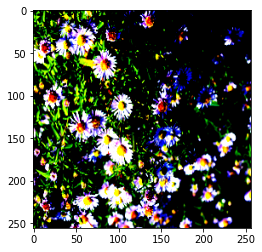

In [26]:
plt.imshow(train_ds[12][0].permute(1,2,0))

# Model Train


In [27]:
import numpy as np
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2
import torch.nn.functional as F


class PDDModel(nn.Module):

    """ 
    This model based on architecture MobileNetV2
    """
    def __init__(self, embedding_size, num_classes, pretrained=False):
        super(PDDModel, self).__init__()

        self.model = mobilenet_v2(pretrained)
        self.embedding_size = embedding_size
        self.model.fc = nn.Linear(embedding_size * 1 * 1, self.embedding_size)
        self.model.classifier = nn.Linear(self.embedding_size, num_classes)

    def l2_norm(self, input):
        input_size = input.size()
        buffer = torch.pow(input, 2)
        normp = torch.sum(buffer, 1).add_(1e-10)
        norm = torch.sqrt(normp)
        _output = torch.div(input, norm.view(-1, 1).expand_as(input))
        output = _output.view(input_size)
        return output

    def forward(self, x):
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        x = self.model.fc(x)
        self.features = self.l2_norm(x)
        alpha = 10
        self.features = self.features * alpha

        return self.features
    
    
    def forward_classifier(self, x):
        features = self.forward(x)
        res = self.model.classifier(features)
        
        return res

# Build model

In [28]:
NUM_CLASSES = len(train_ds.classes)

fix_random_seed(RANDOM_SEED, CUDN_DETERMENISTIC)
model=PDDModel(1280,NUM_CLASSES,True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss = torch.nn.NLLLoss()
# model.load_state_dict(torch.load('triplet.pt'))
# model.load_state_dict(torch.load('triplet_exp1.pt'))
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


# Cycle Train

In [ ]:
import copy
import torch.optim as optim
# Create Lambda function to access data in correct format
train_set_d    = lambda index: train_ds[ index ][0].float( ).numpy( )
test_set_d     = lambda index:  test_ds[ index ][0].float( ).numpy( )

# Hyperparameters
epochs         = 100
batch_size     = 12
n_sample       = 4

fix_random_seed(RANDOM_SEED, CUDN_DETERMENISTIC)

# Triplet Dataset Definition
tri_train_set  = TripletDataset( torch.FloatTensor(train_ds.targets).numpy( ), train_set_d, len(train_ds), n_sample )
tri_test_set   = TripletDataset(  torch.FloatTensor(test_ds.targets),  test_set_d,  len(test_ds),        1 )

# Data Loader
tri_train_load = DataLoader( tri_train_set,
    batch_size  = batch_size,
    shuffle     = True,
    num_workers = 2,
    pin_memory  = True
)
tri_test_load  = DataLoader( tri_test_set,
    batch_size  = batch_size,
    shuffle     = False,
    num_workers = 2,
    pin_memory  = True
)

miner=AllTripletMiner( .5 ).cuda( ) #HardNegativeTripletMiner( .4).cuda( ) # 

#Embedding to np array

In [30]:
def forward_inputs_into_model(loader, model, device,batchsize):
    X = []
    y = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(loader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs).detach().cpu().numpy()
                targets= targets.detach().cpu().numpy()
                if (outputs.shape[0]==batchsize):
                    X.append(outputs)
                    y.append(targets)
    return np.vstack(X), np.hstack(y)  

# Plot

In [31]:
classes=test_ds.classes
def plot(embeddings,labels,classes_name,classes_count,name):
  plt.figure(figsize=(10,10))
  
  for i in range(classes_count):
      inds = np.where(labels==i)[0]
      plt.scatter(embeddings[inds,0],embeddings[inds,1])
  plt.legend(classes_name,loc='center left', bbox_to_anchor=(1, 0.5),prop={"size":25})
  plt.title(name,fontsize=30)
  plt.show()

# Метрики

In [32]:
def knn_acc(test_em,test_labels,train_em,train_labels,n_neighbors,metric):
          knn=KNeighborsClassifier(n_neighbors,metric=metric)
          knn.fit(train_em,train_labels)
          y_pred=knn.predict(test_em)
          msg=f'Knn acc: {metrics.accuracy_score(test_labels,y_pred)} count neighbors: {n_neighbors}'
          print(msg)

# Сохранение модели

In [33]:
import pickle
def save_model(model,optimizer):
          torch.save(model.state_dict(),'triplet_exp1.pt')   
          torch.save(optimizer.state_dict,'optim.pt')
          torch.save(model,'triplet_model.pt')
          # save the model to disk
          filename = 'finalized_model.sav'
          pickle.dump(model, open(filename, 'wb'))         

In [36]:
loss_history=[]
class TripletTrainer(object):
      def __init__(self,
                   model, 
                   optimizer, 
                   tri_train_load,
                   epochs, 
                   tri_test_load,
                   batch_size,
                   KNN_train_data_load,
                   KNN_test_data_load,
                   scheduler
                   ):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = model.to(self.device)
        self.optimizer = optimizer
        # self.loss = loss
        self.epochs = epochs
        self.tri_train_load=tri_train_load
        self.tri_test_load=tri_test_load
        self.batch_size=batch_size
        self.train_loader=KNN_train_data_load
        self.test_loader=KNN_test_data_load
#         self.scheduler=scheduler
        self.loss_history=loss_history


      def train(self):
        for e in tqdm( range( self.epochs ), desc = 'Epoch' ):
            
            test_em,test_labels=forward_inputs_into_model(self.test_loader,self.model,
                                                          self.device,self.batch_size)
            train_em,train_labels=forward_inputs_into_model(self.train_loader,self.model,
                                                            self.device,self.batch_size)
            knn_acc(test_em,test_labels,train_em,train_labels,COUNT_NEIGHBOR_EXP_1,METRIC_KNN)
            knn_acc(test_em,test_labels,train_em,train_labels,COUNT_NEIGHBOR_EXP_2,METRIC_KNN)
            
            plot(train_em,train_labels,classes,NUM_CLASSES,'train_embeddings')
            plot(test_em,test_labels,classes,NUM_CLASSES,'test_embeddings')
            self.train_phase()
            self.validating_phase()
            
            if e % 2 == 0 and e > 0:
                save_model(self.model,self.optimizer)          

      
      def train_phase(self):
        # ================== TRAIN ========================
            train_n        = len( self.tri_train_load )
            train_loss     = 0.
            train_frac_pos = 0.

            

            self.model.train()
            with tqdm( self.tri_train_load, desc = 'Batch' ) as b_pbar:
                for b, batch in enumerate( b_pbar ):
                    self.optimizer.zero_grad()

                    labels, data = batch
                    labels= torch.cat( [ label for label in labels ], axis = 0 )
                    data= torch.cat( [ datum for datum in   data ], axis = 0 )
                    labels= labels.cuda()
                    data= data.cuda()

                    embeddings=model(data)
                    loss, frac_pos=miner(labels, embeddings)
                    loss.backward( )
                    self.optimizer.step()
                    train_loss+= loss.detach( ).item( )
                    train_frac_pos += frac_pos.detach( ).item( ) if frac_pos is not None else \
                                      0.

                    b_pbar.set_postfix(
                        train_loss     = train_loss / train_n,
                        train_frac_pos = f'{( train_frac_pos / train_n ):.2%}'
                    )

      def validating_phase(self):
          val_n        = len( tri_test_load )
          val_loss     = 0.
          val_frac_pos = 0.
          self.model.eval()
          with tqdm( tri_test_load, desc = 'val' ) as b_pbar:
            for b, batch in enumerate( b_pbar ):
              labels, data = batch
              labels= torch.cat( [ label for label in labels ], axis = 0 )
              data= torch.cat( [ datum for datum in   data ], axis = 0 )
              labels= labels.cuda()
              data= data.cuda()
              embeddings=model(data)
              loss, frac_pos=miner(labels, embeddings)
              val_loss+= loss.detach().item()
              loss_history.append(val_loss)
              val_frac_pos += frac_pos.detach().item() if frac_pos is not None else \
                                    0.
              b_pbar.set_postfix(
                      val_loss     = val_loss / val_n,
                      val_frac_pos = f'{( val_frac_pos / val_n ):.2%}'
                  )                             

In [37]:
train_ds, test_ds = prepare_datasets(DATA_PATH) 
fix_random_seed(RANDOM_SEED, CUDN_DETERMENISTIC)
train_loader = torch.utils.data.DataLoader(train_ds, pin_memory=True, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_ds, pin_memory=True, batch_size=batch_size, shuffle=True, num_workers=2)

Load 'flower_photos_ds' data
Load 'flower_photos_ds' data
Train size: 2939
Test size: 731
Number of samples in the dataset: 2939
Crops in the dataset: ['flower_photos']
Total number of classes in the dataset: 5
Classes with the corresponding targets:
{'flower_photos__daisy': 0, 'flower_photos__dandelion': 1, 'flower_photos__roses': 2, 'flower_photos__sunflowers': 3, 'flower_photos__tulips': 4}


Knn acc: 0.8458333333333333 count neighbors: 1
Knn acc: 0.8555555555555555 count neighbors: 3


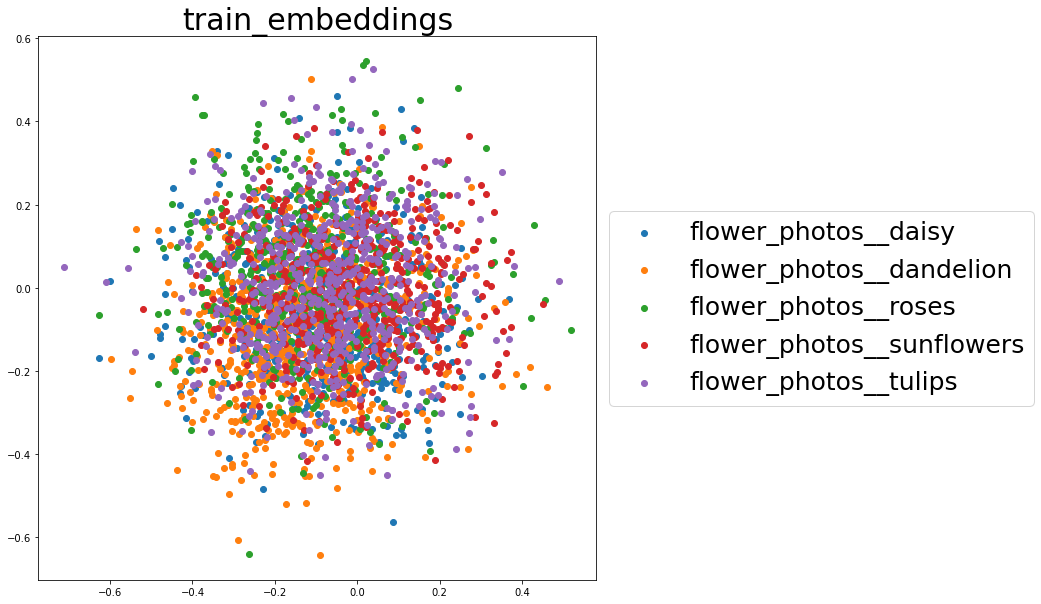

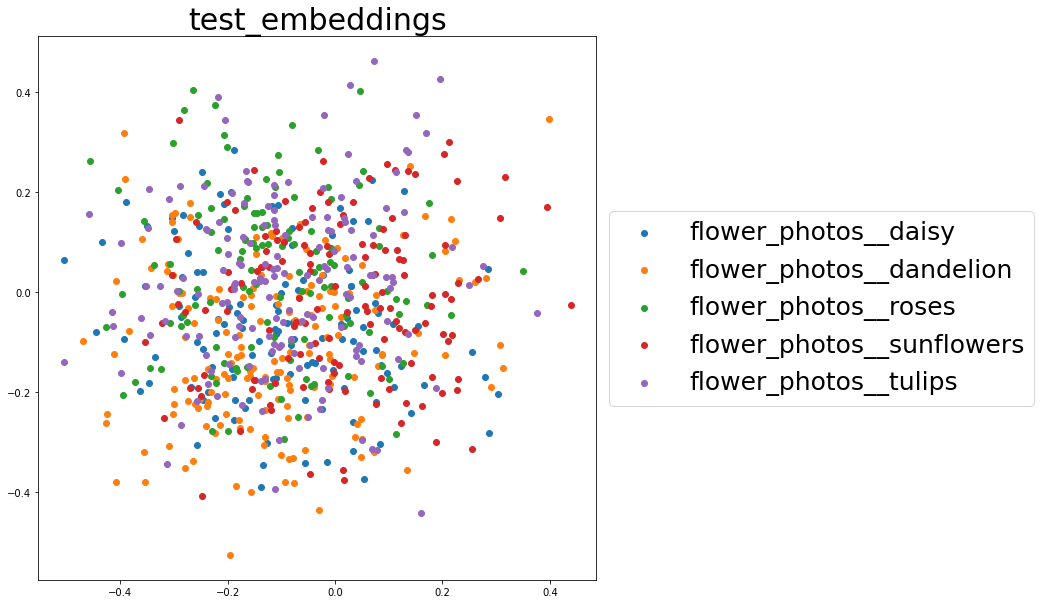


Knn acc: 0.9333333333333333 count neighbors: 1
Knn acc: 0.9291666666666667 count neighbors: 3


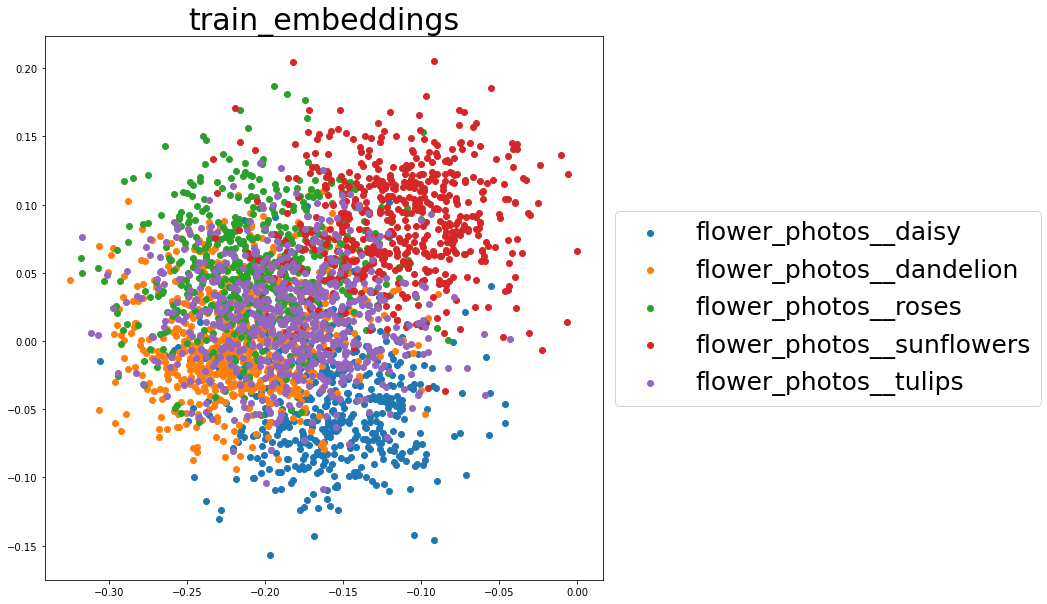

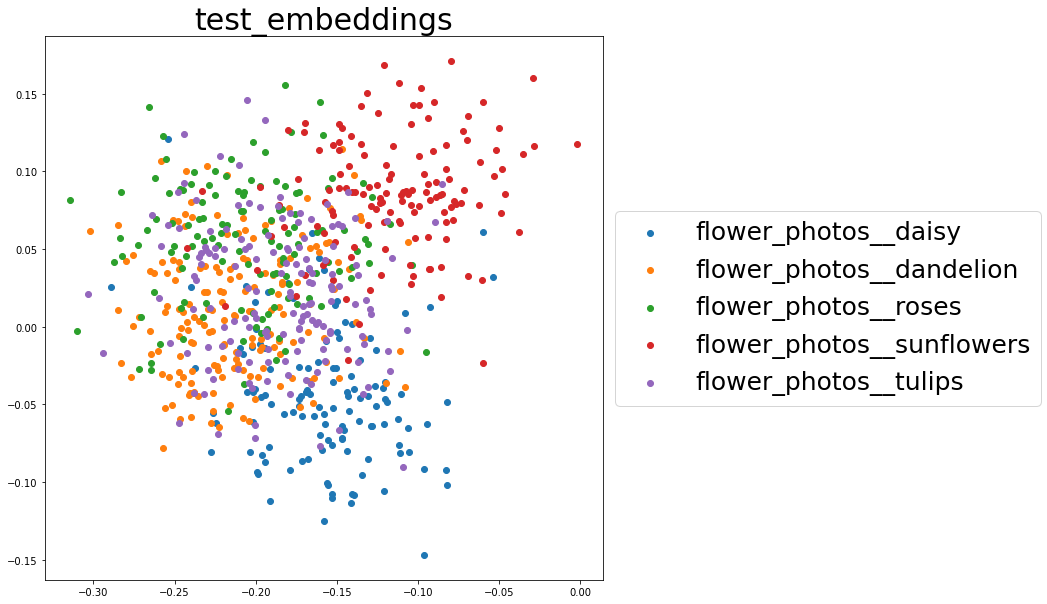


Knn acc: 0.9347222222222222 count neighbors: 1
Knn acc: 0.9347222222222222 count neighbors: 3


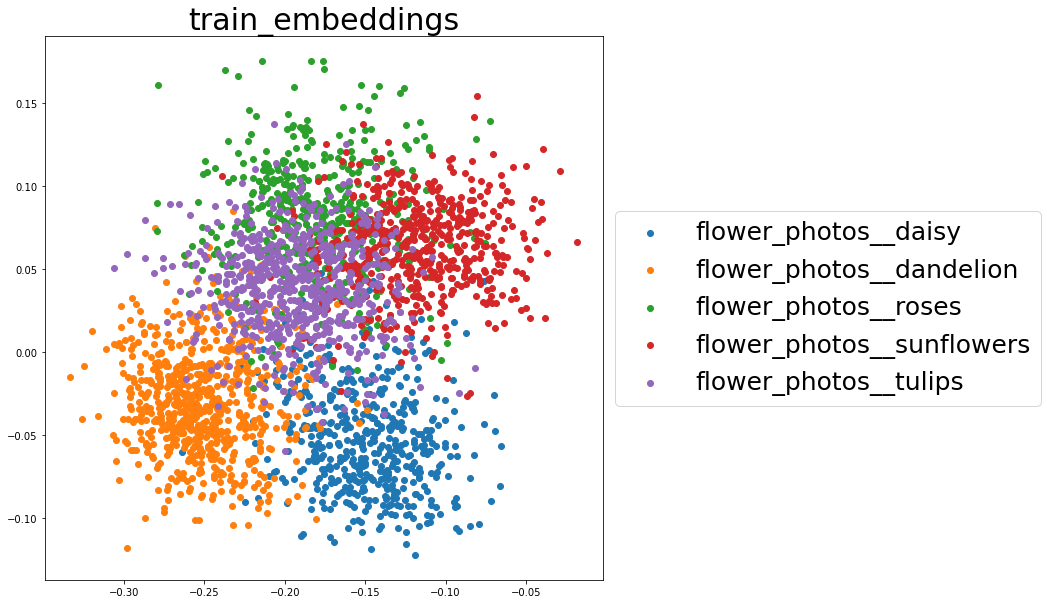

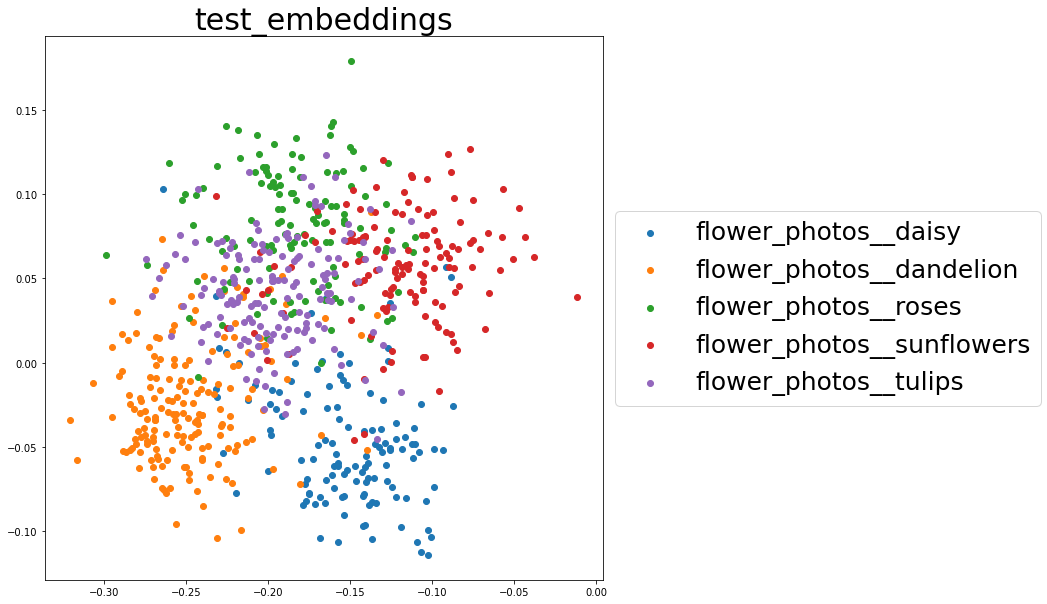


Knn acc: 0.9402777777777778 count neighbors: 1
Knn acc: 0.9444444444444444 count neighbors: 3


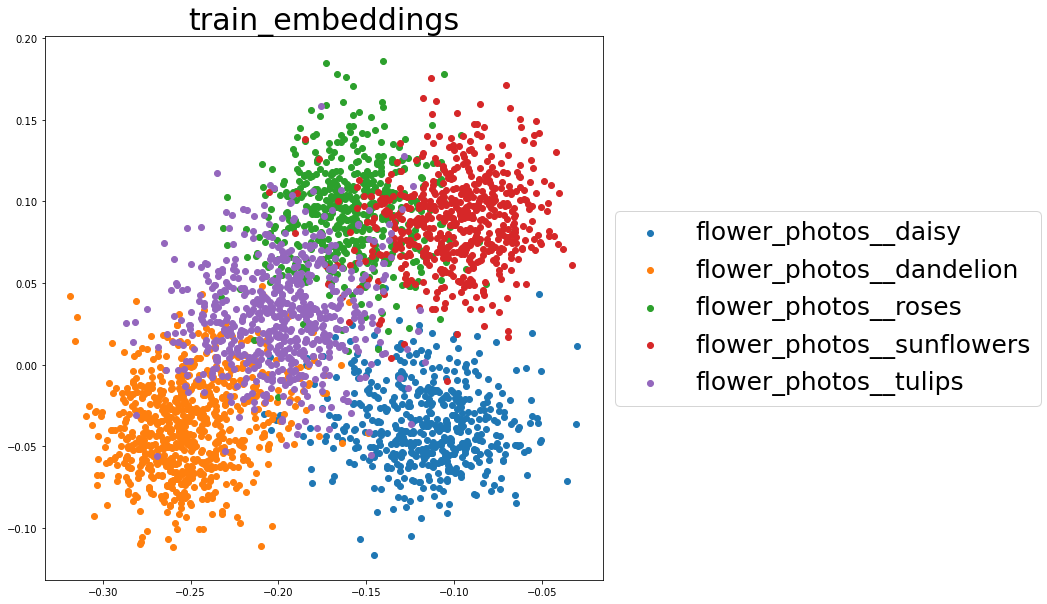

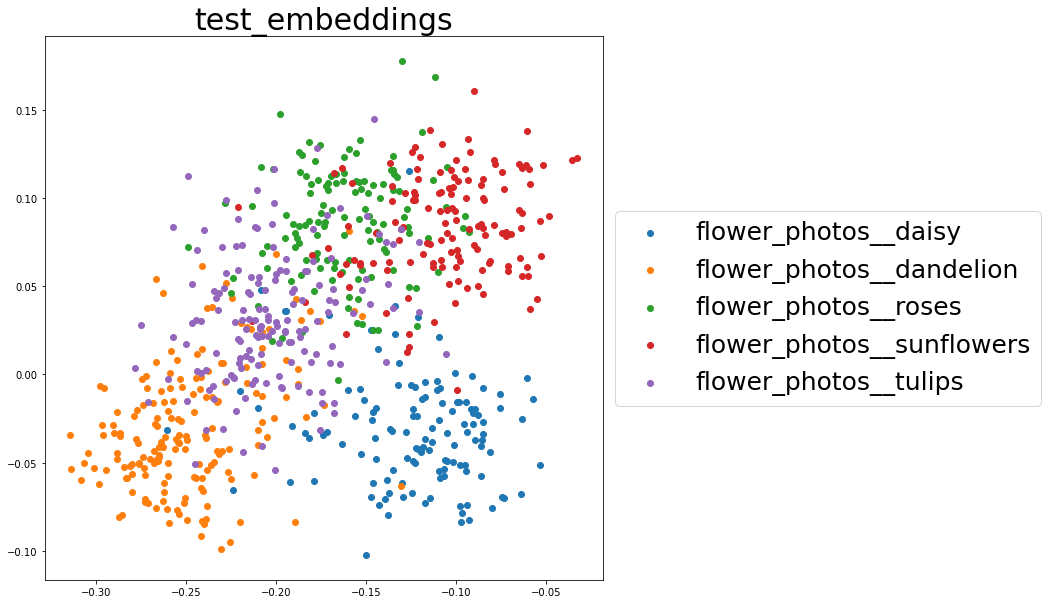

KeyboardInterrupt: ignored

In [38]:
fix_random_seed(RANDOM_SEED, CUDN_DETERMENISTIC)
trainer = TripletTrainer(model=model,
                         optimizer=optimizer,
                         tri_train_load=tri_train_load,
                         epochs=100,
                         tri_test_load=tri_test_load,
                         batch_size=batch_size,
                         KNN_train_data_load=train_loader,
                         KNN_test_data_load=test_loader,
                         scheduler=scheduler)
trainer.train()                     

In [ ]:
torch.cuda.empty_cache() 

In [39]:
!pip install torchbearer

#Классификатор персептрон

#Data utils

In [40]:
def get_trained_model(model, feature_extractor, device):
    model.load_state_dict(
        torch.load(
            feature_extractor,
            map_location=device))
    model.eval()
    return model

def forward_inputs_into_model(loader, model, device, batch_size):
    X = []
    y = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
            if (outputs.shape[0] == batch_size):
                X.append(outputs)
                y.append(targets)
    return np.vstack(X), np.hstack(y)


def save_model(model, optimizer, model_save_path, optim_save_path):
    torch.save(model.state_dict(), model_save_path)
    torch.save(optimizer.state_dict, optim_save_path)

class Perceptron_classifier(nn.Module):
    def __init__(self, emmbeding_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(1280, 512)
        self.fc2 = nn.Linear(512, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        # x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # return x
        return F.log_softmax(x, dim=1)

#Config

In [41]:
RANDOM_SEED=12
CUDN_DETERMENISTIC=True
BATCH_SIZE=32
FEATURE_EXTRACTOR='triplet_exp1.pt'
CLASSIFIER='classifier.pt'



# Обучение персептрона

In [42]:
import torch
import torch.nn as nn
from torchbearer import Trial
from torch.optim import Adam
from torch.autograd import Variable
import torch.nn.functional as F
from torchbearer.callbacks import Best


def train_classifier(model, optimizer, criterion, metrics, train_em, train_labels, test_em, test_labels):
    # optimizer = Adam(model.parameters())
    checkpoint = Best('classifier.pt', monitor='val_acc', mode='max', save_model_params_only=True)
    trial = Trial(model, callbacks=[checkpoint], optimizer=optimizer, criterion=criterion, metrics=['acc'])
    trial.with_train_data(torch.Tensor(train_em), torch.Tensor(train_labels).long()).with_val_data(torch.Tensor(test_em), torch.Tensor(test_labels).long()).for_steps(100).run(40)


def main():
    device = 'cpu'
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        pin_memory=True,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2)
    test_loader = torch.utils.data.DataLoader(
        test_ds,
        pin_memory=True,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2)

    modelpdd = PDDModel(1280, NUM_CLASSES, True)
    modelpdd.to(device)
    modelclassifier = Perceptron_classifier(1280, NUM_CLASSES)
    modelclassifier.to(device)
    modelpdd = get_trained_model(modelpdd, FEATURE_EXTRACTOR, device)
    test_em, test_labels = forward_inputs_into_model(test_loader, modelpdd,
                                                             device, BATCH_SIZE)
    train_em, train_labels = forward_inputs_into_model(train_loader, modelpdd,
                                                               device, BATCH_SIZE)

    optimizer = Adam(modelclassifier.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_classifier(modelclassifier, optimizer, criterion, ['acc'], train_em, train_labels, test_em, test_labels)


if __name__ == "__main__":

    main()


In [ ]:
!ls

archive_full.zip    classifier.pt	 my_path.pt  sample_data
archive_full.zip.1  finalized_model.sav  optim.pt    triplet_exp1.pt
classifieroptim.pt  gdrive		 pdd	     triplet_model.pt


In [43]:
fix_random_seed(RANDOM_SEED, CUDN_DETERMENISTIC)
train_loader = torch.utils.data.DataLoader(train_ds, pin_memory=True, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_ds, pin_memory=True, batch_size=batch_size, shuffle=True, num_workers=2)

In [44]:
import torch.nn as nn
from collections import OrderedDict
import torch


def get_trace_model(embedding_model_path, classifier_model_path, save_path, device, num_classes):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    embedding_model = PDDModel(1280, num_classes, True)
    classifier_model = Perceptron_classifier(1280, num_classes)
    model = nn.Sequential(OrderedDict([
            ('embedding', get_trained_model(embedding_model, embedding_model_path, device)),
            ('classifier', get_trained_model(classifier_model, classifier_model_path, device)),
    ]))
    scripted_model = torch.jit.trace(model, torch.rand(1,3,256,256))
    scripted_model.save(save_path)


def main():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    get_trace_model(FEATURE_EXTRACTOR, CLASSIFIER, 'trace_model.pt', device, NUM_CLASSES)


if __name__ == "__main__":

    main()

In [ ]:
!ls

archive_full.zip    classifier.pt	 my_path.pt  sample_data
archive_full.zip.1  finalized_model.sav  optim.pt    triplet_exp1.pt
classifieroptim.pt  gdrive		 pdd	     triplet_model.pt


In [47]:
f=open('classes2.txt','w')
s1='\n'.join(train_ds.classes)
f.write(s1)
f.close()

In [49]:
cat classes2.txt

flower_photos__daisy
flower_photos__dandelion
flower_photos__roses
flower_photos__sunflowers
flower_photos__tulips